**PROBLEM 1: Aminer : basic dataset analysis**

In [1]:
!wget -O dataset.zip 'https://lfs.aminer.cn/lab-datasets/citation/acm.v9.zip'


--2025-01-18 16:48:43--  https://lfs.aminer.cn/lab-datasets/citation/acm.v9.zip
Resolving lfs.aminer.cn (lfs.aminer.cn)... 159.27.2.14
Connecting to lfs.aminer.cn (lfs.aminer.cn)|159.27.2.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Could not parse String-Transport-Security header
Length: 686542584 (655M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 654.74M  10.6MB/s    in 66s     

2025-01-18 16:49:51 (9.87 MB/s) - ‘dataset.zip’ saved [686542584/686542584]



In [2]:
!unzip dataset.zip -d /content/dataset


Archive:  dataset.zip
  inflating: /content/dataset/acm.txt  


**A. Compute the number of distinct authors, publication venues, publications, and citations/references.**

In [3]:
import pandas as pd

# Path to the dataset file
file_path = '/content/dataset/acm.txt'

# Lists to store parsed data
titles = []
authors = []
years = []
venues = []
indices = []
references = []

# Open and parse the file line by line
with open(file_path, 'r') as file:
    record = {'references': []}  # Add references field to each record
    for line in file:
        line = line.strip()
        if line.startswith("#*"):
            record['title'] = line[2:]  # Title
        elif line.startswith("#@"):
            record['authors'] = line[2:]  # Authors
        elif line.startswith("#t"):
            record['year'] = line[2:]  # Year
        elif line.startswith("#c"):
            record['venue'] = line[2:]  # Venue
        elif line.startswith("#index"):
            record['index'] = line[6:]  # Index
        elif line.startswith("#%"):
            # Append the reference (index of another publication) to the references list
            reference = line[2:].strip()
            if reference:
                record['references'].append(reference)
        elif line == "":
            # End of a record, append to lists
            if record:
                titles.append(record.get('title', ''))
                authors.append(record.get('authors', ''))
                years.append(record.get('year', ''))
                venues.append(record.get('venue', ''))
                indices.append(record.get('index', ''))
                references.append(record.get('references', []))
                record = {'references': []}  # Reset for the next record

# Create a DataFrame from the lists
df = pd.DataFrame({
    'title': titles,
    'authors': authors,
    'year': years,
    'venue': venues,
    'index': indices,
    'references': references
})

In [4]:
df.head()

,title,authors,year,venue,index,references
0,MOSFET table look-up models for circuit simula...,,1984,"Integration, the VLSI Journal",1,[]
1,The verification of the protection mechanisms ...,Virgil D. Gligor,1984,International Journal of Parallel Programming,2,[]
2,Another view of functional and multivalued dep...,"M. Gyssens, J. Paredaens",1984,International Journal of Parallel Programming,3,[]
3,Entity-relationship diagrams which are in BCNF,"Sushil Jajodia, Peter A. Ng, Frederick N. Spri...",1984,International Journal of Parallel Programming,4,[]
4,The computer comes of age,Rene Moreau,1984,The computer comes of age,5,[]


In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
# Number of distinct authors
authors_set = set()
df['authors'].str.split(',').dropna().apply(authors_set.update)
num_authors = len(authors_set)
print(f"Number of distinct authors: {num_authors}")

# Number of distinct venues
num_venues = df['venue'].nunique()
print(f"Number of distinct venues: {num_venues}")

# Number of distinct publications (based on unique titles)
num_publications = df['title'].nunique()
print(f"Number of distinct publications: {num_publications}")

# Note: Dataset example doesn't include references field.

Number of distinct authors: 2027009
Number of distinct venues: 273330
Number of distinct publications: 2183552


**B. Are these numbers likely to be accurate? As an example look up all the publications venue names associated with the conference “Principles and Practice of Knowledge Discovery in Databases” – what do you notice?**


In [7]:
# Filter the dataset for publications associated with the specified conference
conference_name = "Principles and Practice of Knowledge Discovery in Databases"

# Using case-insensitive matching
ppkdd_venues = df[df['venue'].str.contains(conference_name, case=False, na=False)]

unique_ppkdd_venues = ppkdd_venues['venue'].unique()

print("Unique venue names associated with 'Principles and Practice of Knowledge Discovery in Databases':\n")
for venue in unique_ppkdd_venues:
    print(venue)

# Count the number of occurrences for each venue name
venue_counts = ppkdd_venues['venue'].value_counts()

print("\nCounts of publications per venue name:\n")
print(venue_counts)


Unique venue names associated with 'Principles and Practice of Knowledge Discovery in Databases':

PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
Knowledge Discovery in Databases: PKDD 2006: 10th European Conference on Principles and Practice of Knowledge Discovery in Databases, Berlin, Germany, September ... (Lecture Notes in Computer Science)
Knowledge Discovery in Databases: PKDD 2005: 9th European Conference on Principles and Practice of Knowledge Discovery in Databases, Porto, Portugal, October ... / Lecture Notes in Artificial Intelligence)
PKDD 2007 Proceedings of the 11th European conference on Principles and Practice of Knowledge Discovery in Databases
PKDD'05 Proceedings of the 9th European conference on Principles and Practice of Knowledge Discovery in Databases

Counts of publications per venue name:

venue
PKDD'05 Proceedings of the 9th European conference on Principles and Practice of Knowledge Discovery 

It appears as though we have some inconsistent vanue naming conventions, some of our years are abbreviated like PKDD '04 and PKDD 2007.

We also have an inflated count of unique venues. This is because each variation is counted as a distinct venue, causing the inflation.


**C. For each author, construct the list of publications. Plot a histogram of the number of publications per author (use a logarithmic scale on the y axis)**

In [8]:
# Create a dictionary to store publications for each author
author_publications = defaultdict(list)

# Populate the dictionary
for _, row in df.iterrows():
    # Split authors by comma and strip whitespace, filter out empty strings
    authors = [author.strip() for author in row['authors'].split(',') if author.strip()]
    title = row['title']
    for author in authors:
        author_publications[author].append(title)

print("Sample of authors and their publication counts (after cleaning):")
for author, publications in list(author_publications.items())[:15]:
    print(f"Author: {author}, Number of Publications: {len(publications)}")


Sample of authors and their publication counts (after cleaning):
Author: Virgil D. Gligor, Number of Publications: 68
Author: M. Gyssens, Number of Publications: 7
Author: J. Paredaens, Number of Publications: 18
Author: Sushil Jajodia, Number of Publications: 418
Author: Peter A. Ng, Number of Publications: 36
Author: Frederick N. Springsteel, Number of Publications: 8
Author: Rene Moreau, Number of Publications: 1
Author: A. G. Akritas, Number of Publications: 4
Author: S. S. Lyengar, Number of Publications: 2
Author: A. A. Rampuria, Number of Publications: 1
Author: C. C. Chang, Number of Publications: 56
Author: M. W. Du, Number of Publications: 9
Author: R. C. T. Lee, Number of Publications: 59
Author: David Haussler, Number of Publications: 102
Author: Hans Röck, Number of Publications: 2


In [9]:
# List of publication counts for each author
publication_counts = [len(publications) for publications in author_publications.values()]

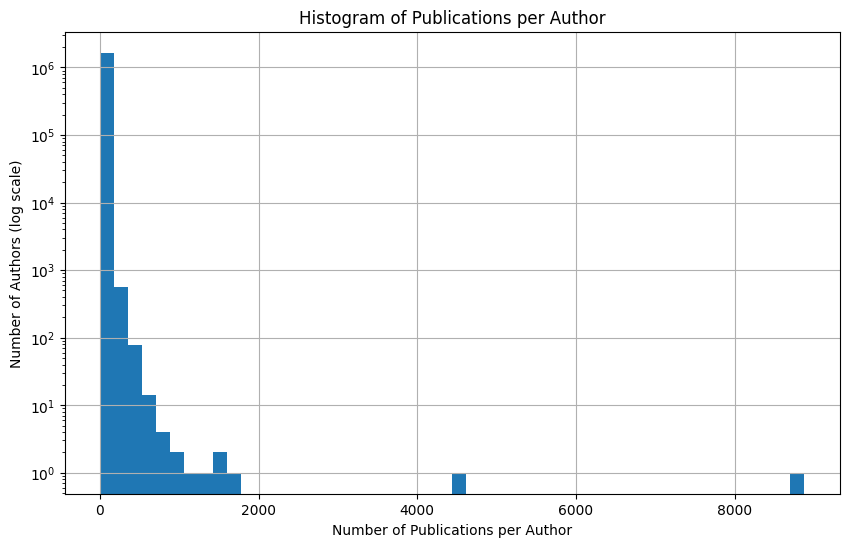

In [10]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(publication_counts, bins=50, log=True)
plt.xlabel('Number of Publications per Author')
plt.ylabel('Number of Authors (log scale)')
plt.title('Histogram of Publications per Author')
plt.grid(True)
plt.show()

**D. Calculate the mean and standard deviation of the number of publications per author. Also calculate the Q1 (1st quartile14), Q2 (2nd quartile, or median) and Q3 (3rd quartile) values. Compare the median to the mean and explain the difference between the two values based on the standard deviation and the 1st and 3rd quartiles.**

In [11]:
import numpy as np

# Calculate statistics
mean_publications = np.mean(publication_counts)
std_dev_publications = np.std(publication_counts)
q1 = np.percentile(publication_counts, 25)  # 1st quartile (25th percentile)
median_publications = np.median(publication_counts)  # 2nd quartile (50th percentile)
q3 = np.percentile(publication_counts, 75)  # 3rd quartile (75th percentile)

# Print results
print(f"Mean number of publications per author: {mean_publications:.2f}")
print(f"Standard deviation: {std_dev_publications:.2f}")
print(f"1st Quartile (Q1): {q1}")
print(f"Median (Q2): {median_publications}")
print(f"3rd Quartile (Q3): {q3}")


Mean number of publications per author: 3.46
Standard deviation: 12.77
1st Quartile (Q1): 1.0
Median (Q2): 1.0
3rd Quartile (Q3): 3.0


The mean represents the average number of publications per author. While the median represents the middle value when the number of publications is sorted.

Interpreting this information lets us know that:
The mean 3.46 is slightly higher than our median of 1.0, this indicates a right-skewed distribution. This means that most authors have very few publications, a small number of authors have significantly more publications, raising our mean.

With our standard deviation of 12.77 being much larger than the mean, this shows us that there is a high variability in the number of publications per author. This reinforces the claim above that a small amount of authors disproportionally dominates the high publication counts.

Quartiles:
Q1 - 25% of authors only have 1 publication or lower.
Median Q2 - 50% of authors have 1 publication of lower.
Q3 - 75% of authors have 3 publications or fewer.
Interquartile range = Q3 - Q1 = 3.0 - 1.0 - 2.0. Shows us that the majority of authors have publication counts in a lower range (1-3 publications).



**E. Now plot a histogram of the number of publications per venue, as well as calculate the mean, standard deviation, median, Q1, and Q3 values. What is the venue with the largest number of publications in the dataset?**

In [12]:
# Calculate the number of publications per venue
venue_publication_counts = df['venue'].value_counts()

# Display the venue with the largest number of publications
most_popular_venue = venue_publication_counts.idxmax()
most_publications = venue_publication_counts.max()

print(f"Venue with the largest number of publications: {most_popular_venue}")
print(f"Number of publications in {most_popular_venue}: {most_publications}")


Venue with the largest number of publications: IEEE Transactions on Information Theory
Number of publications in IEEE Transactions on Information Theory: 12754


In [13]:
import numpy as np

# Convert counts to a list
venue_counts = venue_publication_counts.values

# Calculate statistics
mean_venue_publications = np.mean(venue_counts)
std_dev_venue_publications = np.std(venue_counts)
median_venue_publications = np.median(venue_counts)
q1_venue_publications = np.percentile(venue_counts, 25)
q3_venue_publications = np.percentile(venue_counts, 75)

# Print results
print(f"Mean number of publications per venue: {mean_venue_publications:.2f}")
print(f"Standard deviation: {std_dev_venue_publications:.2f}")
print(f"1st Quartile (Q1): {q1_venue_publications}")
print(f"Median (Q2): {median_venue_publications}")
print(f"3rd Quartile (Q3): {q3_venue_publications}")


Mean number of publications per venue: 8.73
Standard deviation: 106.80
1st Quartile (Q1): 1.0
Median (Q2): 1.0
3rd Quartile (Q3): 1.0


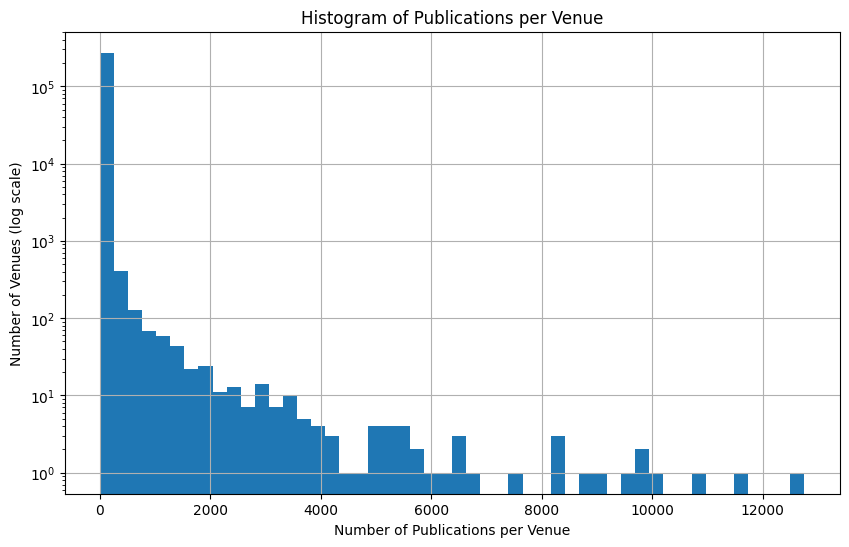

In [14]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(venue_counts, bins=50, log=True)
plt.xlabel('Number of Publications per Venue')
plt.ylabel('Number of Venues (log scale)')
plt.title('Histogram of Publications per Venue')
plt.grid(True)
plt.show()


**F. Plot a histogram of the number of references (number of publications a publication refers to) and citations (number of publications referring to a publication) per publication. What is the publication with the largest number of references? What is the publication with the largest number of citations? Do these make sense?**

In [15]:
# Calculate the number of references per publication
df['num_references'] = df['references'].apply(len)

# Find the publication with the largest number of references
publication_with_most_references = df.loc[df['num_references'].idxmax()]
print("Publication with the largest number of references:")
print(f"Title: {publication_with_most_references['title']}")
print(f"Number of References: {publication_with_most_references['num_references']}")

Publication with the largest number of references:
Title: Proceedings of the Twenty-Fourth ACM Symposium on Operating Systems Principles
Number of References: 809


In [16]:
from itertools import chain
from collections import Counter

# Ensure references are lists
df['references'] = df['references'].apply(lambda x: x if isinstance(x, list) else [])

# Efficiently flatten all references
all_references = chain.from_iterable(df['references'])

# Count citations for each publication index
citation_counts = Counter(all_references)

# Ensure index column is string for consistency
df['index'] = df['index'].astype(str)

# Add citation counts to the DataFrame
df['num_citations'] = df['index'].apply(lambda x: citation_counts.get(x, 0))

# Find the publication with the largest number of citations
publication_with_most_citations = df.loc[df['num_citations'].idxmax()]
print("\nPublication with the largest number of citations:")
print(f"Title: {publication_with_most_citations['title']}")
print(f"Number of Citations: {publication_with_most_citations['num_citations']}")



Publication with the largest number of citations:
Title: INFORMS Journal on Computing
Number of Citations: 938039


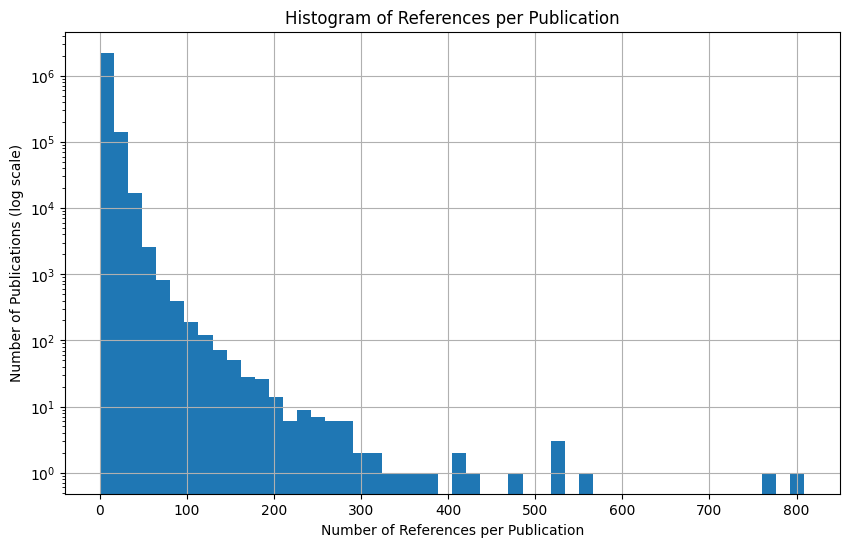

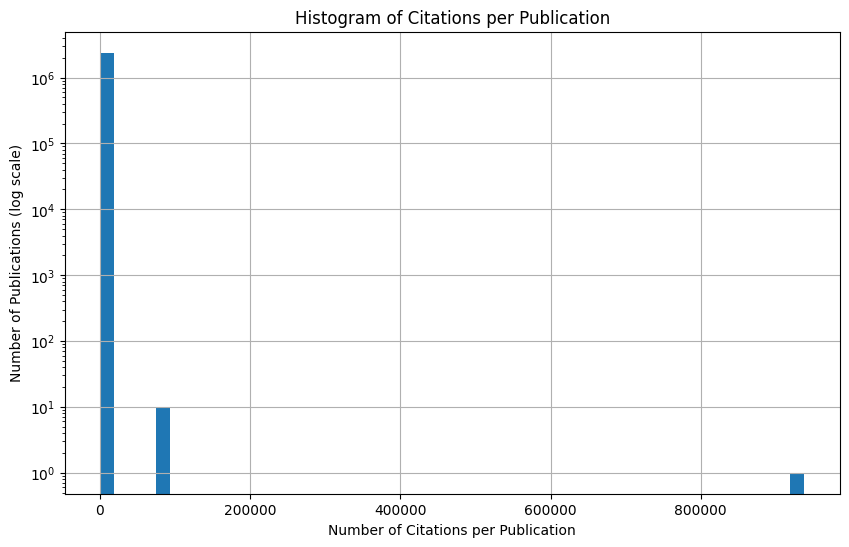

In [17]:
import matplotlib.pyplot as plt

# Plot histogram for number of references
plt.figure(figsize=(10, 6))
plt.hist(df['num_references'], bins=50, log=True)
plt.xlabel('Number of References per Publication')
plt.ylabel('Number of Publications (log scale)')
plt.title('Histogram of References per Publication')
plt.grid(True)
plt.show()

# Plot histogram for number of citations
plt.figure(figsize=(10, 6))
plt.hist(df['num_citations'], bins=50, log=True)
plt.xlabel('Number of Citations per Publication')
plt.ylabel('Number of Publications (log scale)')
plt.title('Histogram of Citations per Publication')
plt.grid(True)
plt.show()

Do these make sense?

Largest number of references is a believable number being at 809. However, 938k citations seems extreme for a publication.

**G. Calculate the so called “impact” factor for each venue. To do so, calculate the total number of citations for the publications in the venue, and then divide this number by the number of publications for the venue. Plot a histogram of the results**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure citation counts are calculated
if 'num_citations' not in df.columns:
    raise ValueError("The DataFrame must include a 'num_citations' column.")

# Group publications by venue
venue_stats = df.groupby('venue').agg(
    total_citations=pd.NamedAgg(column='num_citations', aggfunc='sum'),
    num_publications=pd.NamedAgg(column='index', aggfunc='count')
).reset_index()

# Calculate the impact factor for each venue
venue_stats['impact_factor'] = venue_stats['total_citations'] / venue_stats['num_publications']

# Print top venues by impact factor
print("Top venues by impact factor:")
print(venue_stats.sort_values(by='impact_factor', ascending=False).head(10))

Top venues by impact factor:
                                                    venue  total_citations  \
16127                                             AI EDAM            82080   
108244                                               Graz            82080   
108086                            Graphics Interface 1990            82080   
118727  IJIRR: International Journal of Information Re...            82080   
180842                                              PVLDB            82080   
61629   Computers and Intractability: A Guide to the T...             8620   
105770  Genetic Algorithms in Search, Optimization and...             6526   
249123          The nature of statistical learning theory             5297   
45722                 C4.5: programs for machine learning             4882   
74935   Design patterns: elements of reusable object-o...             4717   

        num_publications  impact_factor  
16127                  1        82080.0  
108244                 1    

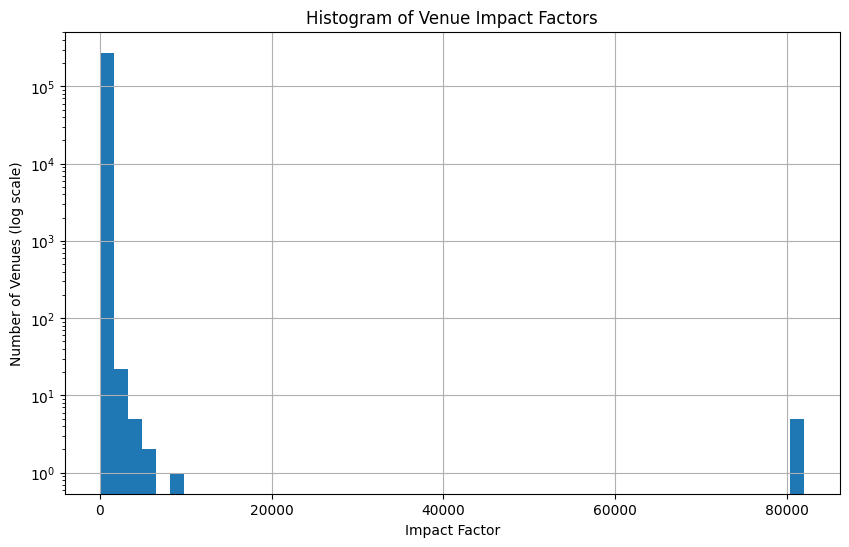

In [19]:
# Plot histogram of impact factors
plt.figure(figsize=(10, 6))
plt.hist(venue_stats['impact_factor'], bins=50, log=True)
plt.xlabel('Impact Factor')
plt.ylabel('Number of Venues (log scale)')
plt.title('Histogram of Venue Impact Factors')
plt.grid(True)
plt.show()

**H. What is the venue with the highest apparent impact factor? Do you believe this number?**

In [20]:
# Find the venue with the highest impact factor
highest_impact_venue = venue_stats.loc[venue_stats['impact_factor'].idxmax()]

# Print the venue details
print("Venue with the highest apparent impact factor:")
print(f"Venue: {highest_impact_venue['venue']}")
print(f"Total Citations: {highest_impact_venue['total_citations']}")
print(f"Number of Publications: {highest_impact_venue['num_publications']}")
print(f"Impact Factor: {highest_impact_venue['impact_factor']}")

Venue with the highest apparent impact factor:
Venue: AI EDAM
Total Citations: 82080
Number of Publications: 1
Impact Factor: 82080.0


Do you believe this number?

No. It appears that a single publication generated an impact factor of 82,080. This exceeds the provided link's impact factor "guide" by an extreme amount.

**I. Now repeat the calculation from item G, but restrict the calculation to venues with at least 10 publications. How does your histogram change? List the citation counts for all publications from the venue with the highest impact factor. How does the impact factor (mean number of citations) compare to the median number of citations?**

In [21]:
# Filter for venues with at least 10 publications
filtered_venue_stats = venue_stats[venue_stats['num_publications'] >= 10]

# Print the filtered statistics
print(f"Number of venues with at least 10 publications: {len(filtered_venue_stats)}")

Number of venues with at least 10 publications: 25641


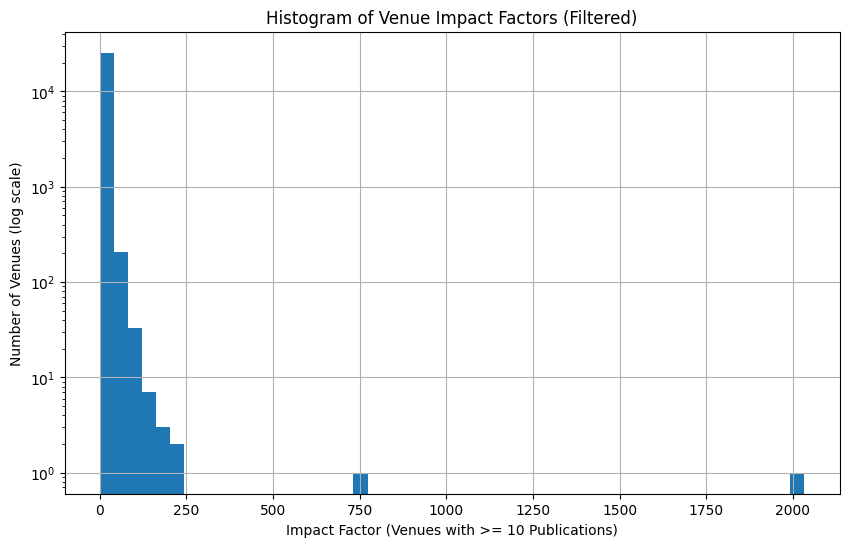

In [22]:
# Plot histogram of impact factors for venues with at least 10 publications
plt.figure(figsize=(10, 6))
plt.hist(filtered_venue_stats['impact_factor'], bins=50, log=True)
plt.xlabel('Impact Factor (Venues with >= 10 Publications)')
plt.ylabel('Number of Venues (log scale)')
plt.title('Histogram of Venue Impact Factors (Filtered)')
plt.grid(True)
plt.show()

In [23]:
# Find the venue with the highest impact factor
highest_filtered_impact_venue = filtered_venue_stats.loc[filtered_venue_stats['impact_factor'].idxmax()]

# Print the venue details
print("\nVenue with the highest impact factor (Filtered):")
print(f"Venue: {highest_filtered_impact_venue['venue']}")
print(f"Total Citations: {highest_filtered_impact_venue['total_citations']}")
print(f"Number of Publications: {highest_filtered_impact_venue['num_publications']}")
print(f"Impact Factor: {highest_filtered_impact_venue['impact_factor']}")


Venue with the highest impact factor (Filtered):
Venue: Proceedings of the 19th ACM SIGKDD international conference on Knowledge discovery and data mining
Total Citations: 410707
Number of Publications: 202
Impact Factor: 2033.2029702970297


In [24]:
# Extract publications from the venue with the highest impact factor
top_venue_publications = df[df['venue'] == highest_filtered_impact_venue['venue']]

# List citation counts
print("\nCitation counts for publications in the top venue:")
print(top_venue_publications[['title', 'num_citations']])


Citation counts for publications in the top venue:
                                                     title  num_citations
1991774  Who, where, when and what: discover spatio-tem...              9
1991775  Multi-label classification by mining label and...              3
1991776  Fast structure learning in generalized stochas...              1
1991777  Accurate intelligible models with pairwise int...              0
1991778  Spotting opinion spammers using behavioral foo...              0
...                                                    ...            ...
2111179         Optimization in learning and data analysis          82080
2111180      The online revolution: education for everyone          82080
2112019     Predicting the present with search engine data          82080
2112020     Predicting the present with search engine data          82080
2112021     Predicting the present with search engine data          82080

[202 rows x 2 columns]


In [25]:
# Calculate mean and median number of citations for the top venue
mean_citations = top_venue_publications['num_citations'].mean()
median_citations = top_venue_publications['num_citations'].median()

print("\nComparison of Mean and Median Citations:")
print(f"Impact Factor (Mean Number of Citations): {mean_citations}")
print(f"Median Number of Citations: {median_citations}")


Comparison of Mean and Median Citations:
Impact Factor (Mean Number of Citations): 2033.2029702970297
Median Number of Citations: 1.0


How does the histogram change?
Limiting the graph to only include more than 10 publications significantly lowers our impact factor down to 2000. Instead of our previous 82080. I beleive this number is still incorrect, as we are looking for an impact factor in the range of 0-20. Looking at the graph shows us that there is still a small outlier which can possibly be removed to help shift the values down.

How does the impact factor compare to the median number of citations?
With an impact factor of 2033, and a median number of citations being at 1 , this suggest that there is still an outlier which is inflating the impact factor.


**J. Finally, construct a list of publications for each publication year. Use this list to plot the average number of references and average number of citations per publication as a function of time. Explain the differences you see in the trends.**

In [26]:
# Group publications by year and calculate the averages
yearly_stats = df.groupby('year').agg(
    avg_references=pd.NamedAgg(column='num_references', aggfunc='mean'),
    avg_citations=pd.NamedAgg(column='num_citations', aggfunc='mean')
).reset_index()

# Drop rows with missing or invalid years
yearly_stats = yearly_stats.dropna(subset=['year']).sort_values(by='year')

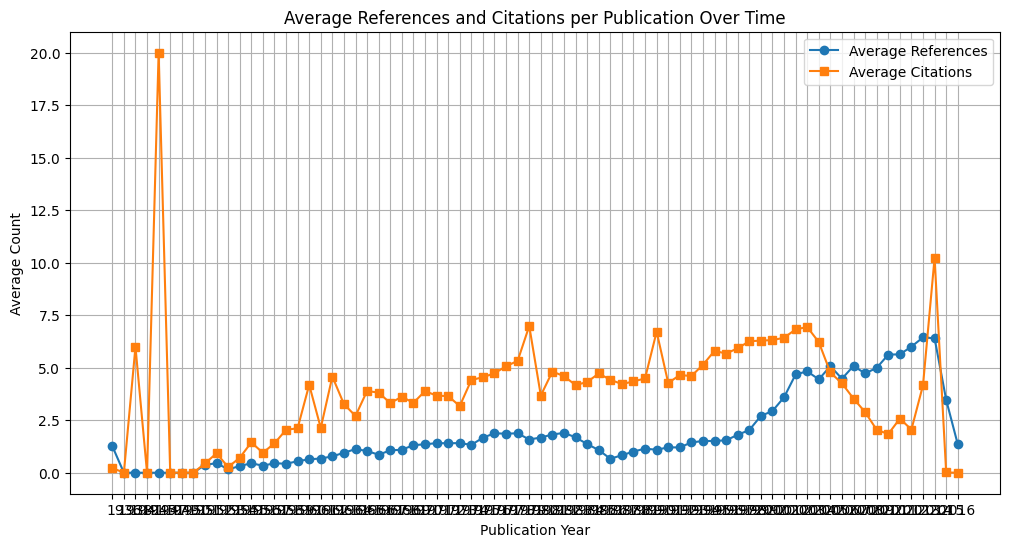

In [27]:
import matplotlib.pyplot as plt

# Plot average number of references over time
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats['year'], yearly_stats['avg_references'], label='Average References', marker='o')
plt.plot(yearly_stats['year'], yearly_stats['avg_citations'], label='Average Citations', marker='s')
plt.xlabel('Publication Year')
plt.ylabel('Average Count')
plt.title('Average References and Citations per Publication Over Time')
plt.legend()
plt.grid(True)
plt.show()

Explain the differences you see in the trends:

In the early years, towards the left of the chart, we see that there is a lot of fluctuation happening in citations. This is likely due to a small sample size of publications. Possibly where some highly cited works are dominating the statistic. Also, the average number of references is low, once again pointing towards a limited number of literature available to site in the early period.

Gradually the average number of references per publication increases as time goes on. Showing the growing collection of academic work, allowing researcher to use more citations.

**Problem 2 : Kosarak Association Rules**

Your task is to take a dataset of nearly one million clicks on a news site16 and use the Weka Explorer to identify interesting association rules. Ordinarily this would be a point-and-click task; however, the input data format is a list of transactions (each line in the file includes a list of anonymized news item id’s), whereas Weka requires a tabular format. Specifically, each distinct news item id should be represented via a column/attribute, and each row/instance should be a sequence of binary values, indicating whether or not the user visited the corresponding news item.

**A. Write a Python program which takes as its argument5 the path to a text file of data (assumed to be in the itemset format above) and produces as output to the console a sparse ARFF file.**

In [28]:
!wget -O /content/kosarak.dat 'http://fimi.uantwerpen.be/data/kosarak.dat'


--2025-01-18 16:55:01--  http://fimi.uantwerpen.be/data/kosarak.dat
Resolving fimi.uantwerpen.be (fimi.uantwerpen.be)... 143.129.69.1
Connecting to fimi.uantwerpen.be (fimi.uantwerpen.be)|143.129.69.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32029467 (31M)
Saving to: ‘/content/kosarak.dat’

/content/kosarak.da 100%[===================>]  30.54M  17.2MB/s    in 1.8s    

2025-01-18 16:55:03 (17.2 MB/s) - ‘/content/kosarak.dat’ saved [32029467/32029467]



In [29]:
!head /content/kosarak.dat


1 2 3
1
4 5 6 7
1 8
9 10
11 6 12 13 14 15 16
1 3 7
17 18
11 6 19 20 21 22 23 24
1 25 3


**B. Use your program to convert the kosarak.dat file to a sparse kosarak.arff. About how long did it take to run?**

In [52]:
import time

def generate_sparse_arff(input_file_path, output_file_path="output.arff"):
    start_time = time.time()

    # Step 1: Parse transactions and unique items
    transactions = []
    unique_items = set()

    print("Reading input file...")
    with open(input_file_path, 'r') as file:
        for line in file:
            items = line.strip().split()
            transactions.append(items)
            unique_items.update(items)

    # Step 2: Sort items numerically for correct attribute order
    sorted_items = sorted(unique_items, key=lambda x: int(x))
    item_to_index = {item: idx for idx, item in enumerate(sorted_items)}
    print(f"Found {len(sorted_items)} unique items.")

    # Step 3: Write the ARFF file
    print("Generating ARFF file...")
    with open(output_file_path, 'w') as arff_file:
        # Write ARFF header
        arff_file.write("% Sparse ARFF file generated from itemset data\n")
        arff_file.write("@RELATION news_clicks\n\n")

        for item in sorted_items:
            arff_file.write(f"@ATTRIBUTE item_{item} {{0,1}}\n")

        arff_file.write("\n@DATA\n")

        # Write transactions as sparse rows
        for row_num, transaction in enumerate(transactions):
            # Remove duplicate items and get sorted indices
            unique_items_in_transaction = set(transaction)
            active_indices = sorted([item_to_index[item] for item in unique_items_in_transaction if item in item_to_index])

            # Write the sparse row
            if active_indices:
                sparse_row = "{" + ",".join(f"{idx} 1" for idx in active_indices) + "}"
                arff_file.write(sparse_row + "\n")

    elapsed_time = time.time() - start_time
    print(f"ARFF file successfully created: {output_file_path}")
    print(f"Time taken: {elapsed_time:.2f} seconds")


# Example usage
input_file_path = "/content/kosarak.dat"  # Path to input file
output_file_path = "/content/kosarak_fixed.arff"  # Path to output file
generate_sparse_arff(input_file_path, output_file_path)

Reading input file...
Found 41270 unique items.
Generating ARFF file...
ARFF file successfully created: /content/kosarak_fixed.arff
Time taken: 13.87 seconds


In [53]:
!head -n 50 /content/kosarak_fixed.arff

% Sparse ARFF file generated from itemset data
@RELATION news_clicks

@ATTRIBUTE item_1 {0,1}
@ATTRIBUTE item_2 {0,1}
@ATTRIBUTE item_3 {0,1}
@ATTRIBUTE item_4 {0,1}
@ATTRIBUTE item_5 {0,1}
@ATTRIBUTE item_6 {0,1}
@ATTRIBUTE item_7 {0,1}
@ATTRIBUTE item_8 {0,1}
@ATTRIBUTE item_9 {0,1}
@ATTRIBUTE item_10 {0,1}
@ATTRIBUTE item_11 {0,1}
@ATTRIBUTE item_12 {0,1}
@ATTRIBUTE item_13 {0,1}
@ATTRIBUTE item_14 {0,1}
@ATTRIBUTE item_15 {0,1}
@ATTRIBUTE item_16 {0,1}
@ATTRIBUTE item_17 {0,1}
@ATTRIBUTE item_18 {0,1}
@ATTRIBUTE item_19 {0,1}
@ATTRIBUTE item_20 {0,1}
@ATTRIBUTE item_21 {0,1}
@ATTRIBUTE item_22 {0,1}
@ATTRIBUTE item_23 {0,1}
@ATTRIBUTE item_24 {0,1}
@ATTRIBUTE item_25 {0,1}
@ATTRIBUTE item_26 {0,1}
@ATTRIBUTE item_27 {0,1}
@ATTRIBUTE item_28 {0,1}
@ATTRIBUTE item_29 {0,1}
@ATTRIBUTE item_30 {0,1}
@ATTRIBUTE item_31 {0,1}
@ATTRIBUTE item_32 {0,1}
@ATTRIBUTE item_33 {0,1}
@ATTRIBUTE item_34 {0,1}
@ATTRIBUTE item_35 {0,1}
@ATTRIBUTE item_36 {0,1}
@ATTRIBUTE item_37 {0,1}
@ATTRIBUTE ite

In [54]:
from google.colab import files
files.download('/content/kosarak_fixed.arff')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**C. Load the resulting file into Weka (as described above; you should have 41,270 attributes and 990, 002 instances). About how long did it take to load this file?**

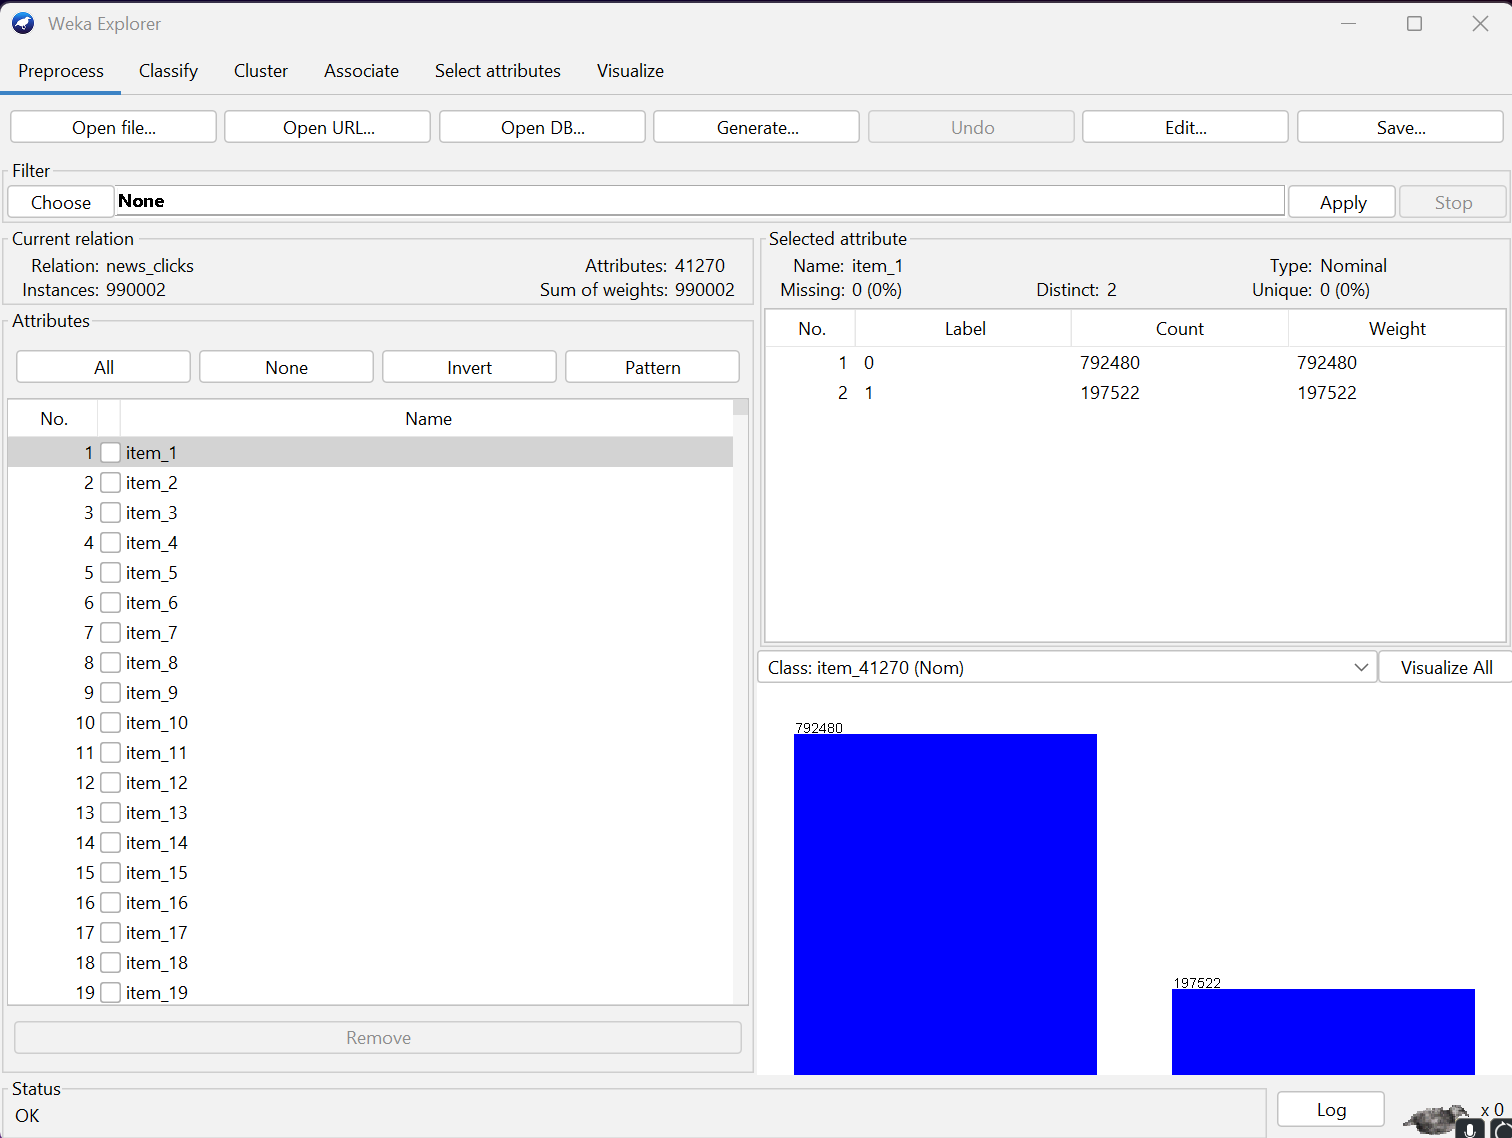

Loading our data in Weka. As can be seen we have 41,270 attributes and 990,002 instances. It took approximately 5 seconds to load in.